# 14.5 2012 Federal Election Commission Database（2012联邦选举委员会数据库）

这个选举数据库对于政治宣传很有用。里面包含了支持者的名字，职业和雇主，地址，赞助金额。一个有意思的数据集是关于2012年美国总统选举的。这个数据集有150MB，名称为P00000001-ALL.csv。（译者：因为github对于单个文件的上传限额是100MB，所以这个数据集无法推送到github上，这里我是把数据集压缩成了ZIP格式，解压后能正常导入）。我们用pandas来加载这个数据集：

In [4]:
import numpy as np
import pandas as pd

In [5]:
pd.options.display.max_rows = 10

In [9]:
fec = pd.read_csv('../datasets/fec/P00000001-ALL.csv', low_memory=False)
# 不设定low_memory=False的话会报错

In [11]:
fec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
cmte_id              1001731 non-null object
cand_id              1001731 non-null object
cand_nm              1001731 non-null object
contbr_nm            1001731 non-null object
contbr_city          1001712 non-null object
contbr_st            1001727 non-null object
contbr_zip           1001620 non-null object
contbr_employer      988002 non-null object
contbr_occupation    993301 non-null object
contb_receipt_amt    1001731 non-null float64
contb_receipt_dt     1001731 non-null object
receipt_desc         14166 non-null object
memo_cd              92482 non-null object
memo_text            97770 non-null object
form_tp              1001731 non-null object
file_num             1001731 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 122.3+ MB


拿出一份记录来看是什么样子：

In [12]:
fec.iloc[123456]

cmte_id             C00431445
cand_id             P80003338
cand_nm         Obama, Barack
contbr_nm         ELLMAN, IRA
contbr_city             TEMPE
                    ...      
receipt_desc              NaN
memo_cd                   NaN
memo_text                 NaN
form_tp                 SA17A
file_num               772372
Name: 123456, Length: 16, dtype: object

我们可以已经能想到如何切割、整理数据，来提取赞助者的统计数据，或提取宣传活动的模式，这里我们展示一些不同的分析方法。

我们可以看到这里面没有政治党派（political party affiliations），所以我们最好添加这样的信息。我们可以使用unique得到所有候选人名单：

In [13]:
unique_cands = fec.cand_nm.unique()
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [14]:
unique_cands[2]

'Obama, Barack'

一种标记政党的方法是使用dict：

In [15]:
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican', 
           'Gingrich, Newt': 'Republican', 
           'Huntsman, Jon': 'Republican', 
           'Johnson, Gary Earl': 'Republican', 
           'McCotter, Thaddeus G': 'Republican', 
           'Obama, Barack': 'Democrat', 
           'Paul, Ron': 'Republican', 
           'Pawlenty, Timothy': 'Republican', 
           'Perry, Rick': 'Republican', 
           "Roemer, Charles E. 'Buddy' III": 'Republican', 
           'Romney, Mitt': 'Republican', 
           'Santorum, Rick': 'Republican'}

用map方法，把这个映射应用到Series对象上，我们可以用候选者名字得到一个政党的数组：

In [16]:
fec.cand_nm[123456:123461]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object

In [17]:
fec.cand_nm[123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [18]:
# Add it as a column
fec['party'] = fec.cand_nm.map(parties)

In [19]:
fec['party'].value_counts()

Democrat      593746
Republican    407985
Name: party, dtype: int64

一些需要注意的地方。首先，这个数据集中包含捐款和退款（退款表示把捐赠的钱退还给捐助者，用负数表示）：

In [20]:
(fec.contb_receipt_amt > 0).value_counts()

True     991475
False     10256
Name: contb_receipt_amt, dtype: int64

为了简化之后的分析过程，这里我们只取捐款的数据，不考虑退款的数据：

In [21]:
fec = fec[fec.contb_receipt_amt > 0]

因为Barack Obama和Mitt Romney是两个最主要的候选者，所以这里我们单独准备一个子集来包含二人的数据：

In [22]:
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]

# 1 Donation Statistics by Occupation and Employer（按职业与雇主划分的捐赠数据）

职业与捐赠也是有关系的。例如，律师倾向于给民主党（Democrats）捐更多的钱，而企业主管（business executives）倾向给共和党（Republicans）捐更多的钱。

首先，按职业计算捐赠总额：

In [23]:
fec.contbr_occupation.value_counts()[:10]

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: contbr_occupation, dtype: int64

可以看到有些职业是同一种工作类型，指代的是同一个东西。下面用一小段代码来清理一下，把一些职业映射为另一种；注意dict.get方法，它会无视没有映射关系的职业：

In [24]:
occ_mapping = { 
    'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED', 
    'INFORMATION REQUESTED' : 'NOT PROVIDED', 
    'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED', 
    'C.E.O.': 'CEO' 
}

# If no mapping provided, return x 
f = lambda x: occ_mapping.get(x, x) 
fec.contbr_occupation = fec.contbr_occupation.map(f)

/Users/xu/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


译者：上面这个warning我觉得也有必要好好了解一下，这个网站做了很好的讲解，[Understanding SettingwithCopyWarning in pandas](https://www.dataquest.io/blog/settingwithcopywarning/)。

简单的说，pandas会在遇到Chained assignment的情况时，跳出这个SettingWithCopyWarning。Chained assignment指的是`data[data.bidder == 'parakeet2004']['bidderrate'] = 100`这样的情况，即把两个索引操作连在一起。

- data[data.bidder == 'parakeet2004']
- ['bidderrate'] = 100

这两个连续操作是分别独立执行的，一个结束后，另一个才开始。第一个操作是一个访问（access）方法，这个方法会返回一个新的DataFrame。而第二个方法是一个赋值（assignment）方法，这个方法是作用在新产生的DataFrame上，所以这里的100是赋给了新的DataFrame，原始的DataFrame并没有被更改。所以为了防止这样的情况出现，pandas会发出SettingWithCopyWarning，让我们检查一下有没有出错。

那就检查一下呗，下面输出fec.contbr_occupation，发现映射关系被正常执行了，所以这里的warning我们可以忽略：

In [25]:
fec.contbr_occupation

0                               RETIRED
1                               RETIRED
2                          NOT PROVIDED
3                               RETIRED
4                               RETIRED
                       ...             
1001726                    NOT PROVIDED
1001727                  BUSINESS OWNER
1001728                    NOT PROVIDED
1001729    LONGWALL MAINTENANCE FOREMAN
1001730                    NOT PROVIDED
Name: contbr_occupation, Length: 991475, dtype: object

对雇主也做同样的映射处理：

In [26]:
emp_mapping = { 
    'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED', 
    'INFORMATION REQUESTED' : 'NOT PROVIDED', 
    'SELF' : 'SELF-EMPLOYED', 
    'SELF EMPLOYED' : 'SELF-EMPLOYED', 
}

# If no mapping provided, return x 
f = lambda x: emp_mapping.get(x, x) 
fec.contbr_employer = fec.contbr_employer.map(f)

/Users/xu/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [27]:
fec.contbr_employer

0                               RETIRED
1                               RETIRED
2                          NOT PROVIDED
3                                  NONE
4                                  NONE
                       ...             
1001726                    NOT PROVIDED
1001727    DUFFY EQUIPMENT COMPANY INC.
1001728                    NOT PROVIDED
1001729                        T.A.C.C.
1001730                    NOT PROVIDED
Name: contbr_employer, Length: 991475, dtype: object

现在，我们可以用pivot_table，按政党和职业对数据进行聚合，然后过滤下得到捐赠额大于两百万美元以上的职业：

In [28]:
by_occupation = fec.pivot_table('contb_receipt_amt', 
                                index='contbr_occupation',
                                columns='party',
                                aggfunc='sum')

In [30]:
over_2mm = by_occupation[by_occupation.sum(1) > 2000000]
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7.477194e+06
CEO,2074974.79,4.211041e+06
CONSULTANT,2459912.71,2.544725e+06
ENGINEER,951525.55,1.818374e+06
EXECUTIVE,1355161.05,4.138850e+06
...,...,...
PRESIDENT,1878509.95,4.720924e+06
PROFESSOR,2165071.08,2.967027e+05
REAL ESTATE,528902.09,1.625902e+06


画出柱状图，barh表示水平柱状图：

In [34]:
import seaborn as sns
%matplotlib inline

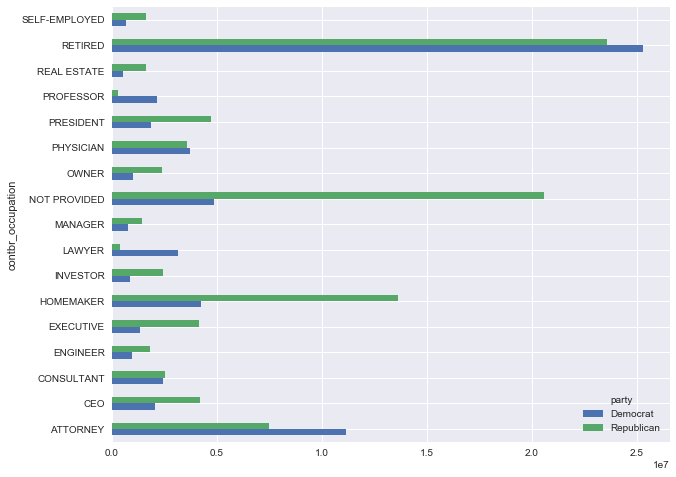

In [35]:
over_2mm.plot(kind='barh', figsize=(10, 8))

我们可以能对那些捐款给Obama和Romney的顶级捐助者职业，或顶级捐助公司感兴趣。想要得到这些信息的话，可以按候选者名字进行分组，然后使用top方法的一个变形：

In [39]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    return totals.nlargest(n)

然后按职业和雇主聚合：

In [40]:
grouped = fec_mrbo.groupby('cand_nm')
grouped

In [41]:
grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

cand_nm        contbr_occupation    
Obama, Barack  RETIRED                  25305116.38
               ATTORNEY                 11141982.97
               INFORMATION REQUESTED     4866973.96
               HOMEMAKER                 4248875.80
               PHYSICIAN                 3735124.94
                                           ...     
Romney, Mitt   HOMEMAKER                 8147446.22
               ATTORNEY                  5364718.82
               PRESIDENT                 2491244.89
               EXECUTIVE                 2300947.03
               C.E.O.                    1968386.11
Name: contb_receipt_amt, Length: 14, dtype: float64

In [42]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

cand_nm        contbr_employer      
Obama, Barack  RETIRED                  22694358.85
               SELF-EMPLOYED            17080985.96
               NOT EMPLOYED              8586308.70
               INFORMATION REQUESTED     5053480.37
               HOMEMAKER                 2605408.54
                                           ...     
Romney, Mitt   CREDIT SUISSE              281150.00
               MORGAN STANLEY             267266.00
               GOLDMAN SACH & CO.         238250.00
               BARCLAYS CAPITAL           162750.00
               H.I.G. CAPITAL             139500.00
Name: contb_receipt_amt, Length: 20, dtype: float64

# 2 Bucketing Donation Amounts（桶捐赠额）

一个分析这种数据的有用方法是使用cut函数，把捐赠额去中心化，按捐赠额大小分为多个桶：

In [43]:
bins = np.array([0, 1, 10, 100, 1000, 10000,
                 100000, 1000000, 10000000])

In [44]:
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)
labels

411         (10, 100]
412       (100, 1000]
413       (100, 1000]
414         (10, 100]
415         (10, 100]
             ...     
701381      (10, 100]
701382    (100, 1000]
701383        (1, 10]
701384      (10, 100]
701385    (100, 1000]
Name: contb_receipt_amt, Length: 694282, dtype: category
Categories (8, interval[int64]): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

我们可以按二人的名字和箱标签（bin label）分组，得到按不同捐赠额的直方图：

In [45]:
grouped = fec_mrbo.groupby(['cand_nm', labels])
grouped.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493.0,77.0
"(1, 10]",40070.0,3681.0
"(10, 100]",372280.0,31853.0
"(100, 1000]",153991.0,43357.0
"(1000, 10000]",22284.0,26186.0
"(10000, 100000]",2.0,1.0
"(100000, 1000000]",3.0,NaN
"(1000000, 10000000]",4.0,NaN


这份数据说明Obama收到的小额捐助是远超Romney的。我们也可以对每一个箱进行归一化，然后得到百分比数据：

In [46]:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)
bucket_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",318.24,77.00
"(1, 10]",337267.62,29819.66
"(10, 100]",20288981.41,1987783.76
"(100, 1000]",54798531.46,22363381.69
"(1000, 10000]",51753705.67,63942145.42
"(10000, 100000]",59100.00,12700.00
"(100000, 1000000]",1490683.08,NaN
"(1000000, 10000000]",7148839.76,NaN


In [47]:
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)
normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,NaN
"(1000000, 10000000]",1.000000,NaN


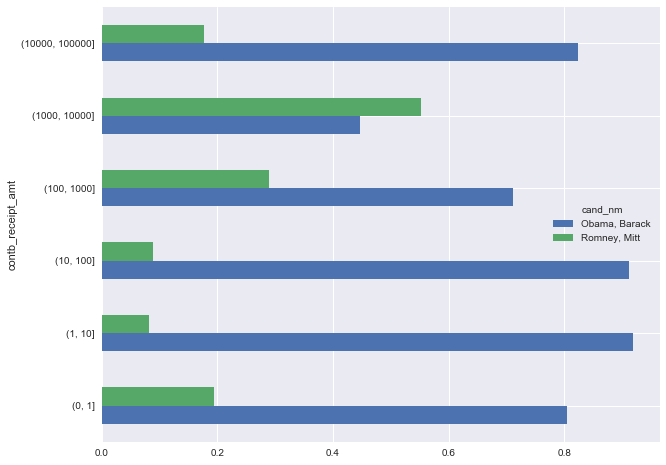

In [49]:
normed_sums[:-2].plot(kind='barh', figsize=(10, 8))

这里没有包含捐款数额最大的两个bins，因为没有Romney这边没有捐款。

# 3 Donation Statistics by State（按州划分的捐赠数据）

按州划分也是一个比较常见的方法：

In [54]:
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st'])

In [55]:
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)
totals

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AA,56405.00,135.00
AB,2048.00,0.00
AE,42973.75,5680.00
AK,281840.15,86204.24
AL,543123.48,527303.51
...,...,...
WI,1130155.46,270316.32
WV,169154.47,126725.12
WY,194046.74,252595.84


In [57]:
totals = totals[totals.sum(1) > 100000]
totals

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
...,...,...
WA,4250933.16,1341521.56
WI,1130155.46,270316.32
WV,169154.47,126725.12


还可以得到每个州，两个候选人获得金额的百分比：

In [58]:
percent = totals.div(totals.sum(1), axis=0)
percent[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224
